In [ ]:
# STEP 1: Environment setup & configuration

# Install required libraries (run this once at the start of the session)
!pip -q install biopython xgboost torch torchvision scikit-learn matplotlib

import os, json, random, re, zipfile
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Create a working directory for the whole project
ROOT = Path("/content/cgr_project")
ROOT.mkdir(exist_ok=True, parents=True)
print("Project folder:", ROOT)

# Configuration for the project
CONFIG = {
    "virus_families": [
        "Adenoviridae",
        "Coronaviridae",
        "Orthomyxoviridae",
        "Paramyxoviridae",
        "Picornaviridae",
        "Rhabdoviridae",
        "Caliciviridae",
        "Papillomaviridae"
    ],
    "max_genomes_per_family": 120,   # cap per family to keep it manageable
    "test_split": 0.15,
    "val_split": 0.15,
    "cgr_k": 6,                      # CGR resolution parameter
    "img_size": 256,                 # image size (256x256)
    "batch_size": 32,
    "epochs": 8,                     # can increase later if time allows
    "learning_rate": 1e-3,
    "seed": 42
}

json.dump(CONFIG, open(ROOT / "config.json", "w"), indent=2)
print("CONFIG:")
print(json.dumps(CONFIG, indent=2))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.0 MB/s eta 0:00:00
Project folder: /content/cgr_project
CONFIG:
{
  "virus_families": [
    "Adenoviridae",
    "Coronaviridae",
    "Orthomyxoviridae",
    "Paramyxoviridae",
    "Picornaviridae",
    "Rhabdoviridae",
    "Caliciviridae",
    "Papillomaviridae"
  ],
  "max_genomes_per_family": 120,
  "test_split": 0.15,
  "val_split": 0.15,
  "cgr_k": 6,
  "img_size": 256,
  "batch_size": 32,
  "epochs": 8,
  "learning_rate": 0.001,
  "seed": 42
}


In [ ]:
# STEP 2: Download viral genomes from NCBI RefSeq into FASTA files

from Bio import Entrez, SeqIO
from io import StringIO
import time

# 🔴 CHANGE THIS TO YOUR REAL EMAIL BEFORE RUNNING
Entrez.email = "axm7745@mavs.uta.edu"

fa_dir = ROOT / "fasta"
fa_dir.mkdir(exist_ok=True)

def download_family_genomes(family, max_per_family):
    print(f"\n=== Downloading {family} ===")
    # Search for complete RefSeq genomes for this virus family
    term = f'"{family}"[Organism] AND Viruses[Organism] AND "complete genome"[Title] AND refseq[filter]'
    search_handle = Entrez.esearch(db="nuccore", term=term, retmax=max_per_family)
    search_results = Entrez.read(search_handle)
    search_handle.close()
    id_list = search_results["IdList"]
    print(f"Found {len(id_list)} records in NCBI")

    if not id_list:
        return 0

    batch_size = 50  # fetch in chunks so URLs aren't too long
    saved = 0

    for i in range(0, len(id_list), batch_size):
        batch_ids = id_list[i:i + batch_size]
        print(f"  Fetching records {i+1}–{i+len(batch_ids)} ...")
        fetch_handle = Entrez.efetch(
            db="nuccore",
            id=",".join(batch_ids),
            rettype="fasta",
            retmode="text"
        )
        fasta_text = fetch_handle.read()
        fetch_handle.close()

        # Parse the multi-FASTA response and save each genome as its own file
        records = list(SeqIO.parse(StringIO(fasta_text), "fasta"))
        for rec in records:
            seq_str = str(rec.seq)
            # Skip tiny sequences, we want real genomes
            if len(seq_str) < 1000:
                continue

            out_path = fa_dir / f"{family}_{rec.id}.fasta"
            with open(out_path, "w") as f:
                f.write(f">{rec.id}\n")
                for j in range(0, len(seq_str), 80):
                    f.write(seq_str[j:j+80] + "\n")
            saved += 1

        # Be nice to NCBI, don't spam
        time.sleep(0.3)

    print(f"Saved {saved} genomes for {family}")
    return saved

total = 0
for fam in CONFIG["virus_families"]:
    total += download_family_genomes(fam, CONFIG["max_genomes_per_family"])

print("\nTotal genomes saved:", total)
print("FASTA files in", fa_dir, "=>", len(list(fa_dir.glob('*.fasta'))))



=== Downloading Adenoviridae ===
Found 110 records in NCBI
  Fetching records 1–50 ...
  Fetching records 51–100 ...
  Fetching records 101–110 ...
Saved 110 genomes for Adenoviridae

=== Downloading Coronaviridae ===
Found 69 records in NCBI
  Fetching records 1–50 ...
  Fetching records 51–69 ...
Saved 69 genomes for Coronaviridae

=== Downloading Orthomyxoviridae ===
Found 0 records in NCBI

=== Downloading Paramyxoviridae ===
Found 82 records in NCBI
  Fetching records 1–50 ...
  Fetching records 51–82 ...
Saved 82 genomes for Paramyxoviridae

=== Downloading Picornaviridae ===
Found 120 records in NCBI
  Fetching records 1–50 ...
  Fetching records 51–100 ...
  Fetching records 101–120 ...
Saved 120 genomes for Picornaviridae

=== Downloading Rhabdoviridae ===
Found 120 records in NCBI
  Fetching records 1–50 ...
  Fetching records 51–100 ...
  Fetching records 101–120 ...
Saved 120 genomes for Rhabdoviridae

=== Downloading Caliciviridae ===
Found 43 records in NCBI
  Fetching r

Total FASTA files found: 664


/tmp/ipython-input-399022092.py:60: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(img, mode="L")  # grayscale


CGR images created: 664

Images per family:
  Papillomaviridae: 120
  Rhabdoviridae: 120
  Picornaviridae: 120
  Adenoviridae: 110
  Paramyxoviridae: 82
  Coronaviridae: 69
  Caliciviridae: 43


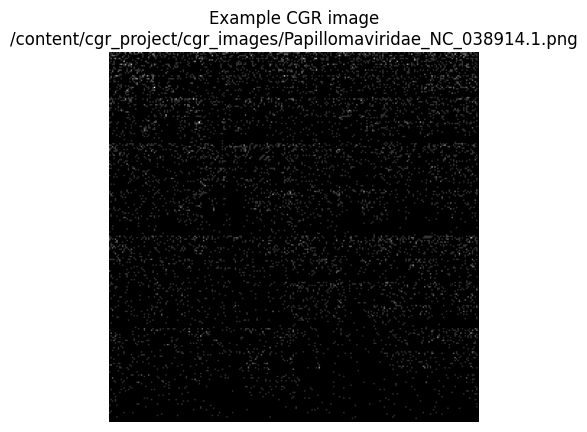

In [ ]:
# STEP 3: Convert viral genomes (FASTA) into CGR images

from PIL import Image
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

fa_dir = ROOT / "fasta"
img_dir = ROOT / "cgr_images"
img_dir.mkdir(exist_ok=True)

def sanitize_seq(seq: str) -> str:
    """Keep only A,C,G,T,N and uppercase everything."""
    seq = seq.upper()
    allowed = set("ACGTN")
    return "".join(ch if ch in allowed else "N" for ch in seq)

def read_fasta_single(path: Path) -> str:
    """Read a FASTA file and return the concatenated sequence."""
    seq_lines = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith(">"):
                continue
            seq_lines.append(line.strip())
    return sanitize_seq("".join(seq_lines))

def cgr_image(sequence: str, size: int = 256) -> Image.Image:
    """
    Generate a Chaos Game Representation (CGR) image from a DNA sequence.
    Simple version: A,C,G,T mapped to corners of a square; walk and increment pixels.
    """
    corners = {
        "A": (0.0, 0.0),
        "C": (0.0, 1.0),
        "G": (1.0, 1.0),
        "T": (1.0, 0.0)
    }
    x, y = 0.5, 0.5  # start at center
    img = np.zeros((size, size), dtype=np.float32)

    for base in sequence:
        if base not in corners:
            continue
        cx, cy = corners[base]
        # move halfway toward the corner
        x = 0.5 * (x + cx)
        y = 0.5 * (y + cy)
        ix = min(size - 1, max(0, int(x * (size - 1))))
        iy = min(size - 1, max(0, int(y * (size - 1))))
        img[iy, ix] += 1.0

    # normalize to 0–255
    if img.max() > 0:
        img = img / img.max()
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img, mode="L")  # grayscale

paths = []
labels = []

fasta_files = list(fa_dir.glob("*.fasta"))
print("Total FASTA files found:", len(fasta_files))

for fasta_path in fasta_files:
    # family name is the first part of the filename before the first underscore
    family = fasta_path.name.split("_")[0]
    seq = read_fasta_single(fasta_path)

    # skip very short sequences (likely fragments)
    if len(seq) < 2000:
        continue

    img = cgr_image(seq, size=CONFIG["img_size"])
    out_name = fasta_path.stem + ".png"
    out_path = img_dir / out_name
    img.save(out_path)

    paths.append(str(out_path))
    labels.append(family)

print("CGR images created:", len(paths))

# Save arrays for later steps
paths = np.array(paths)
labels = np.array(labels)
np.save(ROOT / "paths.npy", paths)
np.save(ROOT / "labels.npy", labels)

# Quick sanity check: count per family
counts = Counter(labels)
print("\nImages per family:")
for fam, cnt in counts.items():
    print(f"  {fam}: {cnt}")

# Show one example CGR image
if len(paths) > 0:
    ex_path = paths[0]
    ex_img = Image.open(ex_path)
    plt.imshow(ex_img, cmap="gray")
    plt.title(f"Example CGR image\n{ex_path}")
    plt.axis("off")
    plt.show()
else:
    print("No images were generated - check sequence lengths and filters.")


In [ ]:
# STEP 4: Create train / validation / test splits

from collections import defaultdict

# Load the arrays we saved in Step 3
paths = np.load(ROOT / "paths.npy", allow_pickle=True)
labels = np.load(ROOT / "labels.npy", allow_pickle=True)

print("Total images:", len(paths))

# Group image paths by virus family
by_family = defaultdict(list)
for p, y in zip(paths, labels):
    by_family[y].append(p)

# Balance and shuffle within each family
balanced_paths = []
balanced_labels = []

max_per_family = CONFIG["max_genomes_per_family"]

for fam, items in by_family.items():
    items = list(items)
    random.shuffle(items)
    # cap at max_per_family to keep things balanced
    items = items[:max_per_family]
    balanced_paths.extend(items)
    balanced_labels.extend([fam] * len(items))

# Shuffle all together
indices = list(range(len(balanced_paths)))
random.shuffle(indices)
balanced_paths = [balanced_paths[i] for i in indices]
balanced_labels = [balanced_labels[i] for i in indices]

# Compute split sizes
n = len(balanced_paths)
n_test = int(CONFIG["test_split"] * n)
n_val  = int(CONFIG["val_split"] * n)

test_paths = balanced_paths[:n_test]
test_labels = balanced_labels[:n_test]

val_paths  = balanced_paths[n_test:n_test + n_val]
val_labels = balanced_labels[n_test:n_test + n_val]

train_paths  = balanced_paths[n_test + n_val:]
train_labels = balanced_labels[n_test + n_val:]

print(f"Total balanced images: {n}")
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Quick count per split
def count_per_family(names, fams):
    d = defaultdict(int)
    for f in fams:
        d[f] += 1
    return d

print("\nTrain counts per family:")
for fam, cnt in count_per_family(train_paths, train_labels).items():
    print(f"  {fam}: {cnt}")

print("\nVal counts per family:")
for fam, cnt in count_per_family(val_paths, val_labels).items():
    print(f"  {fam}: {cnt}")

print("\nTest counts per family:")
for fam, cnt in count_per_family(test_paths, test_labels).items():
    print(f"  {fam}: {cnt}")

# Save the splits for later
np.save(ROOT / "train_paths.npy", np.array(train_paths))
np.save(ROOT / "train_labels.npy", np.array(train_labels))
np.save(ROOT / "val_paths.npy",   np.array(val_paths))
np.save(ROOT / "val_labels.npy",  np.array(val_labels))
np.save(ROOT / "test_paths.npy",  np.array(test_paths))
np.save(ROOT / "test_labels.npy", np.array(test_labels))


Total images: 664
Total balanced images: 664
Train: 466, Val: 99, Test: 99

Train counts per family:
  Picornaviridae: 91
  Papillomaviridae: 80
  Coronaviridae: 45
  Rhabdoviridae: 82
  Paramyxoviridae: 58
  Adenoviridae: 79
  Caliciviridae: 31

Val counts per family:
  Picornaviridae: 9
  Paramyxoviridae: 12
  Rhabdoviridae: 22
  Papillomaviridae: 18
  Adenoviridae: 16
  Coronaviridae: 15
  Caliciviridae: 7

Test counts per family:
  Picornaviridae: 20
  Rhabdoviridae: 16
  Papillomaviridae: 22
  Caliciviridae: 5
  Coronaviridae: 9
  Adenoviridae: 15
  Paramyxoviridae: 12


**A) Load train/val/test splits**

In [ ]:
# STEP 5A: Load train/val/test splits

train_paths = np.load(ROOT / "train_paths.npy", allow_pickle=True)
train_labels = np.load(ROOT / "train_labels.npy", allow_pickle=True)
val_paths   = np.load(ROOT / "val_paths.npy", allow_pickle=True)
val_labels  = np.load(ROOT / "val_labels.npy", allow_pickle=True)
test_paths  = np.load(ROOT / "test_paths.npy", allow_pickle=True)
test_labels = np.load(ROOT / "test_labels.npy", allow_pickle=True)

print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))


Train: 466 Val: 99 Test: 99


**(B) Function to map image path → genome sequence**

In [ ]:
# STEP 5B: Recover genome sequences from FASTA for each path

def load_sequence_from_img_path(img_path):
    stem = Path(img_path).stem  # e.g., "Adenoviridae_NC_003899.1"
    fasta_path = fa_dir / (stem + ".fasta")
    if fasta_path.exists():
        seq = read_fasta_single(fasta_path)
        return seq
    return None


**C) Convert sequences into k-mer “documents”**

In [ ]:
# STEP 5C: Create k-mer documents for XGBoost baseline

k = 6

def seq_to_kmers(seq, k=6):
    words = []
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if "N" not in kmer:  # skip unknowns
            words.append(kmer)
    return " ".join(words)

def build_kmer_dataset(paths):
    docs = []
    for p in paths:
        seq = load_sequence_from_img_path(p)
        if seq is None:
            docs.append("")
        else:
            docs.append(seq_to_kmers(seq, k=k))
    return docs

train_docs = build_kmer_dataset(train_paths)
val_docs   = build_kmer_dataset(val_paths)
test_docs  = build_kmer_dataset(test_paths)

print("Example k-mer doc:")
print(train_docs[0][:500])


Example k-mer doc:
GCCATC CCATCC CATCCG ATCCGT TCCGTA CCGTAG CGTAGG GTAGGT TAGGTT AGGTTC GGTTCT GTTCTG TTCTGG TCTGGT CTGGTA TGGTAA GGTAAG GTAAGG TAAGGT AAGGTT AGGTTC GGTTCC GTTCCA TTCCAT TCCATC CCATCA CATCAA ATCAAC TCAACT CAACTG AACTGT ACTGTT CTGTTG TGTTGG GTTGGG TTGGGG TGGGGC GGGGCG GGGCGC GGCGCT GCGCTA CGCTAG GCTAGT CTAGTT TAGTTG AGTTGC GTTGCT TTGCTA TGCTAT GCTATG CTATGA TATGAC ATGACC TGACCG GACCGC ACCGCA CCGCAT CGCATT GCATTC CATTCA ATTCAC TTCACG TCACGG CACGGA ACGGAC CGGACG GGACGG GACGGA ACGGAT CGGATG GGATGA GAT


**(D) Vectorize k-mers + Train XGBoost**

In [ ]:
# STEP 5D: Vectorize and train XGBoost baseline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

# Turn k-mer documents into numeric vectors
vectorizer = CountVectorizer(min_df=5)  # ignore very rare kmers
X_train = vectorizer.fit_transform(train_docs)
X_val   = vectorizer.transform(val_docs)
X_test  = vectorizer.transform(test_docs)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_val   = le.transform(val_labels)
y_test  = le.transform(test_labels)

print("Train shape:", X_train.shape)

# Train XGBoost
clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    n_jobs=-1
)

clf.fit(X_train, y_train)

# Evaluate
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
macro_f1 = f1_score(y_test, preds, average="macro")

print("XGBoost Test Accuracy:", acc)
print("XGBoost Macro-F1:", macro_f1)


Train shape: (466, 4096)
XGBoost Test Accuracy: 0.9595959595959596
XGBoost Macro-F1: 0.9424963924963926


**6A — Create Dataset & Dataloaders**

In [ ]:
# STEP 6A: PyTorch dataset and dataloaders for CGR images

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reload splits (just to be safe)
train_paths = np.load(ROOT / "train_paths.npy", allow_pickle=True)
train_labels = np.load(ROOT / "train_labels.npy", allow_pickle=True)
val_paths   = np.load(ROOT / "val_paths.npy", allow_pickle=True)
val_labels  = np.load(ROOT / "val_labels.npy", allow_pickle=True)
test_paths  = np.load(ROOT / "test_paths.npy", allow_pickle=True)
test_labels = np.load(ROOT / "test_labels.npy", allow_pickle=True)

# Get sorted list of families (classes)
classes = sorted(list(set(train_labels.tolist() + val_labels.tolist() + test_labels.tolist())))
print("Classes:", classes)

class CGRDataset(Dataset):
    def __init__(self, paths, labels, classes, train=True):
        self.paths = list(paths)
        self.labels = list(labels)
        self.classes = classes

        if train:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(CONFIG["img_size"], scale=(0.9, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("L")  # grayscale
        img = self.transform(img)
        # ResNet expects 3 channels → repeat grayscale 3 times
        img = img.repeat(3, 1, 1)
        y = self.classes.index(label)
        return img, y

train_ds = CGRDataset(train_paths, train_labels, classes, train=True)
val_ds   = CGRDataset(val_paths,   val_labels,   classes, train=False)
test_ds  = CGRDataset(test_paths,  test_labels,  classes, train=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


Using device: cuda
Classes: ['Adenoviridae', 'Caliciviridae', 'Coronaviridae', 'Papillomaviridae', 'Paramyxoviridae', 'Picornaviridae', 'Rhabdoviridae']


(466, 99, 99)

**6B — Define & Train ResNet18**

In [ ]:
# STEP 6B: Define and train ResNet18 on CGR images

torch.manual_seed(CONFIG["seed"])

# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Replace final fully-connected layer
resnet.fc = torch.nn.Linear(resnet.fc.in_features, len(classes))
resnet = resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=CONFIG["learning_rate"])

best_val_acc = 0.0
best_path = ROOT / "resnet18_best.pt"

for epoch in range(CONFIG["epochs"]):
    # ---- Training ----
    resnet.train()
    total = 0
    correct = 0
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = resnet(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Validation ----
    resnet.eval()
    v_total = 0
    v_correct = 0
    v_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = resnet(xb)
            loss = criterion(outputs, yb)
            v_loss += loss.item() * yb.size(0)
            preds = outputs.argmax(dim=1)
            v_correct += (preds == yb).sum().item()
            v_total += yb.size(0)

    val_loss = v_loss / v_total
    val_acc = v_correct / v_total

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model_state": resnet.state_dict(), "classes": classes}, best_path)

    print(f"Epoch {epoch+1}/{CONFIG['epochs']}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")

print("Best validation accuracy:", best_val_acc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 64.8MB/s]


Epoch 1/8: train_loss=1.3014, train_acc=0.530, val_loss=5.2673, val_acc=0.091
Epoch 2/8: train_loss=0.7480, train_acc=0.715, val_loss=17.2469, val_acc=0.242
Epoch 3/8: train_loss=0.6654, train_acc=0.730, val_loss=1.4474, val_acc=0.465
Epoch 4/8: train_loss=0.4476, train_acc=0.813, val_loss=3.9338, val_acc=0.253
Epoch 5/8: train_loss=0.4328, train_acc=0.852, val_loss=0.7404, val_acc=0.788
Epoch 6/8: train_loss=0.4371, train_acc=0.835, val_loss=1.0200, val_acc=0.636
Epoch 7/8: train_loss=0.3647, train_acc=0.873, val_loss=0.7854, val_acc=0.697
Epoch 8/8: train_loss=0.3400, train_acc=0.873, val_loss=1.9075, val_acc=0.596
Best validation accuracy: 0.7878787878787878


**6C — Evaluate on Test Set + Confusion Matrix**

ResNet18 Test Accuracy: 0.7575757575757576
ResNet18 Test Macro-F1: 0.7405613439009555


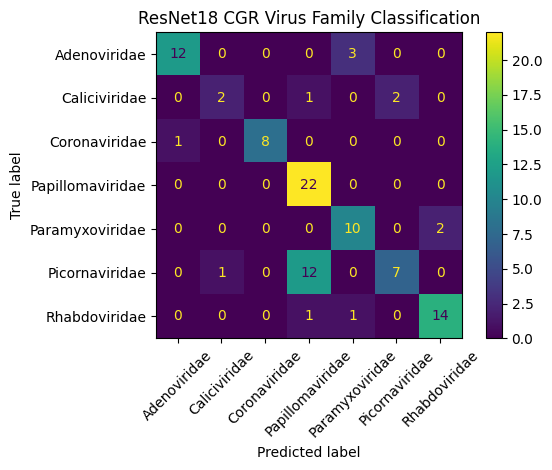

In [ ]:
# STEP 6C: Evaluate best ResNet18 model on the test set

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load best model
ckpt = torch.load(best_path, map_location=device)
resnet.load_state_dict(ckpt["model_state"])
classes = ckpt["classes"]

resnet.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = resnet(xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_pred.extend(preds)
        all_true.extend(yb.numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)

test_acc = accuracy_score(all_true, all_pred)
test_macro_f1 = f1_score(all_true, all_pred, average="macro")

print("ResNet18 Test Accuracy:", test_acc)
print("ResNet18 Test Macro-F1:", test_macro_f1)

# Confusion matrix
cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("ResNet18 CGR Virus Family Classification")
plt.tight_layout()
plt.show()


**7A. Add a new code cell and paste this (Grad-CAM helper)**

In [ ]:
# FIXED STEP 7A: Grad-CAM implementation for ResNet18 (2D heatmap)

import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None   # will be (B, C, H, W)
        self.gradients = None     # will be (B, C, H, W)

        # forward hook
        self.fwd_hook = target_layer.register_forward_hook(self.save_activation)
        # backward hook
        self.bwd_hook = target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output[0] has same shape as activations: (B, C, H, W)
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        """
        x: tensor of shape (1, 3, H, W)
        class_idx: target class index; if None, use predicted class
        Returns a 2D numpy array heatmap with values in [0, 1].
        """
        self.model.zero_grad()
        out = self.model(x)  # (1, num_classes)

        if class_idx is None:
            class_idx = out.argmax(dim=1).item()

        score = out[0, class_idx]
        score.backward()

        # activations & gradients: (1, C, H, W)
        act = self.activations        # (1, C, H, W)
        grad = self.gradients         # (1, C, H, W)

        # average gradients over H,W → weights (1, C, 1, 1)
        weights = grad.mean(dim=(2, 3), keepdim=True)

        # weighted sum of activations over channels → (1, H, W)
        cam = (weights * act).sum(dim=1)   # (1, H, W)

        # remove batch dimension → (H, W)
        cam = cam.squeeze(0).cpu().numpy()

        # ReLU + normalize
        cam = np.maximum(cam, 0)
        max_val = cam.max()
        if max_val > 0:
            cam /= max_val

        return cam

# target last conv layer of ResNet18
target_layer = resnet.layer4[-1].conv2
gradcam = GradCAM(resnet, target_layer)
print("Grad-CAM fixed and ready.")


Grad-CAM fixed and ready.


**7B. Add another cell to visualize Grad-CAM on some test images**

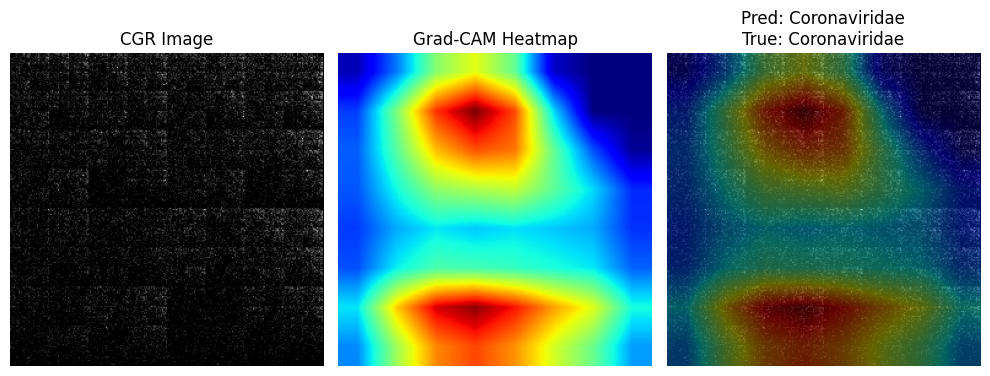

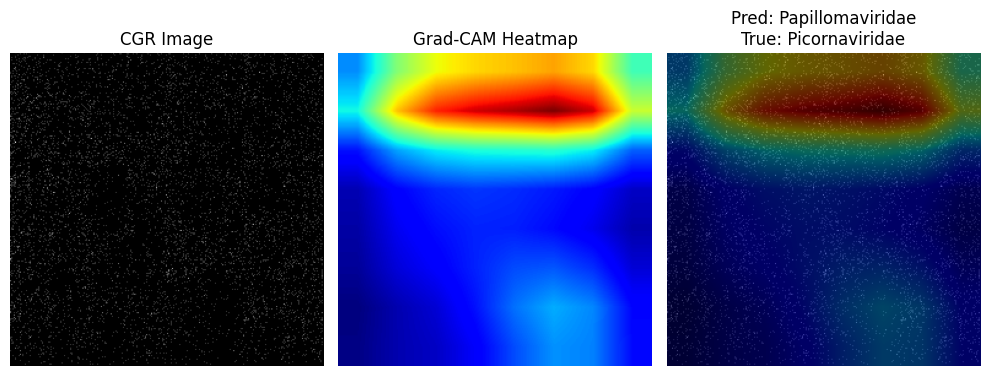

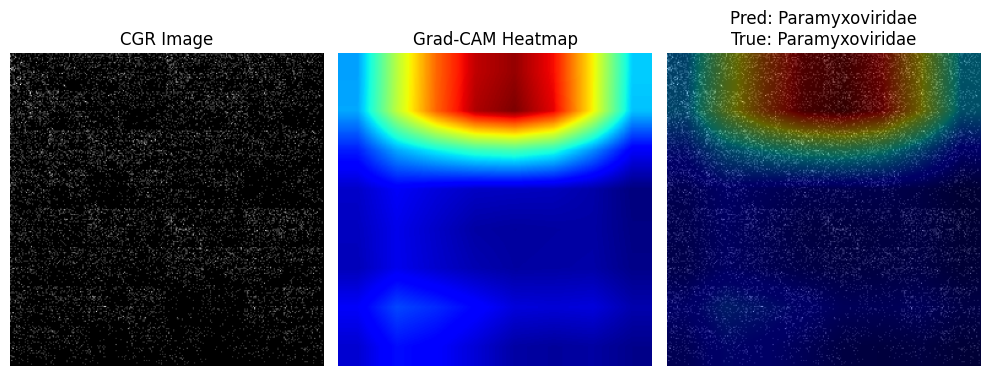

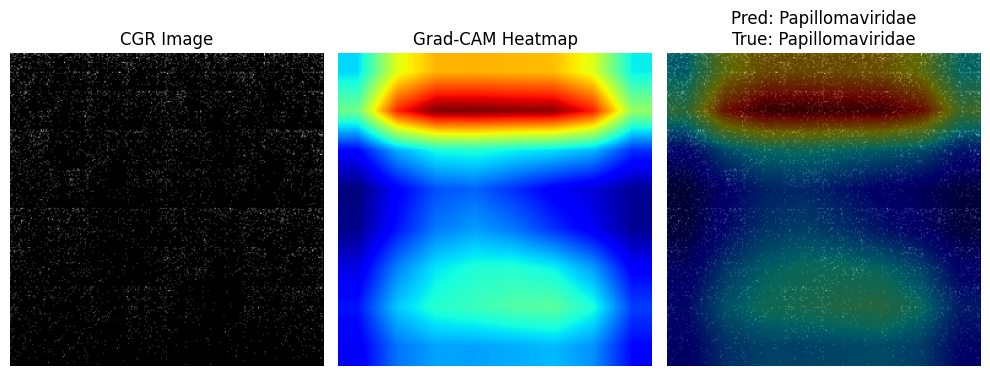

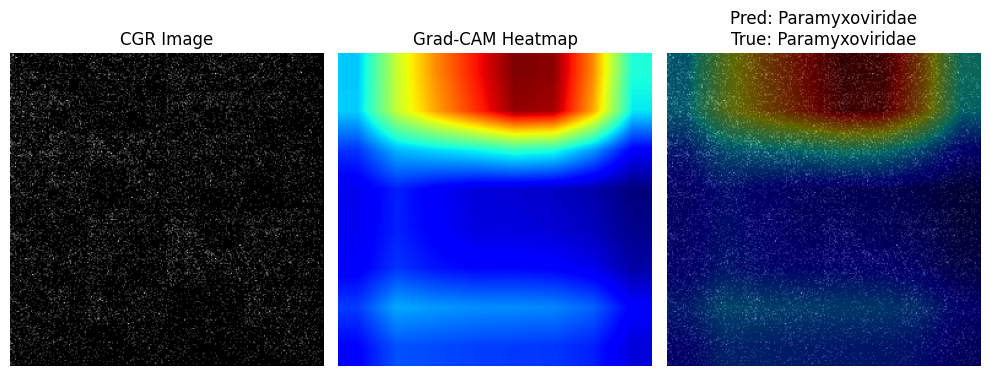

In [ ]:
# STEP 7B: Run Grad-CAM on a few test images and visualize

import random

# transform for evaluation (same as in dataset, but directly)
eval_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor()
])

def show_gradcam_on_image(img_path, true_label=None):
    # load image
    img = Image.open(img_path).convert("L")
    img_t = eval_transform(img)
    img_t = img_t.repeat(3, 1, 1).unsqueeze(0).to(device)  # (1,3,H,W)

    # get prediction
    resnet.eval()
    with torch.no_grad():
        outputs = resnet(img_t)
        pred_idx = outputs.argmax(dim=1).item()
    pred_label = classes[pred_idx]

    # compute Grad-CAM heatmap
    heatmap = gradcam(img_t, class_idx=pred_idx)

    # resize heatmap to image size
    heatmap_resized = np.array(Image.fromarray(heatmap).resize(img.size, resample=Image.BILINEAR))

    # overlay heatmap on original grayscale image
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    plt.title("CGR Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img, cmap="gray")
    plt.imshow(heatmap_resized, cmap="jet", alpha=0.4)
    title = f"Pred: {pred_label}"
    if true_label is not None:
        title += f"\nTrue: {true_label}"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# pick a few random test examples
indices = random.sample(range(len(test_paths)), k=5)

for idx in indices:
    p = test_paths[idx]
    y = test_labels[idx]
    show_gradcam_on_image(p, true_label=y)


**8A. Re-plot & save the confusion matrix**

---



ResNet18 Test Accuracy: 0.7575757575757576
ResNet18 Test Macro-F1: 0.7405613439009555
Saved confusion matrix to: /content/cgr_project/resnet18_confusion_matrix.png


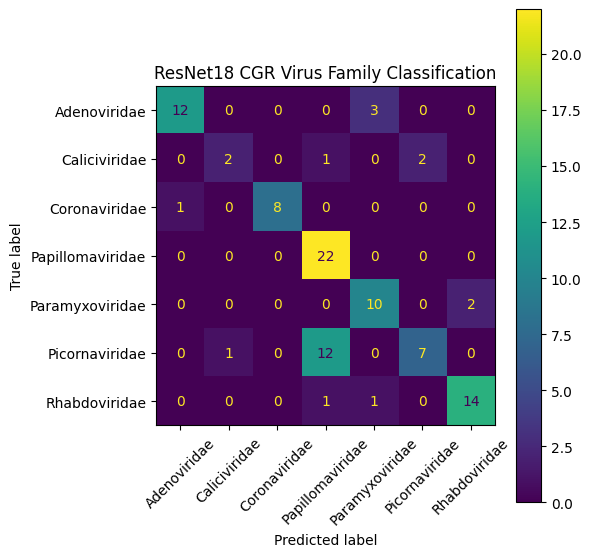

In [ ]:
# STEP 8A: Recreate & SAVE the confusion matrix figure

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Recompute predictions to be safe
resnet.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = resnet(xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_pred.extend(preds)
        all_true.extend(yb.numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)

test_acc = accuracy_score(all_true, all_pred)
test_macro_f1 = f1_score(all_true, all_pred, average="macro")

print("ResNet18 Test Accuracy:", test_acc)
print("ResNet18 Test Macro-F1:", test_macro_f1)

cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("ResNet18 CGR Virus Family Classification")
plt.tight_layout()

# 🔽 SAVE
cm_path = ROOT / "resnet18_confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
print("Saved confusion matrix to:", cm_path)
plt.show()


**8B. Save ONE nice Grad-CAM figure**

Image path: /content/cgr_project/cgr_images/Adenoviridae_NC_020487.1.png
True family: Adenoviridae
Predicted family: Adenoviridae


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved Grad-CAM figure to: /content/cgr_project/resnet18_gradcam_example.png


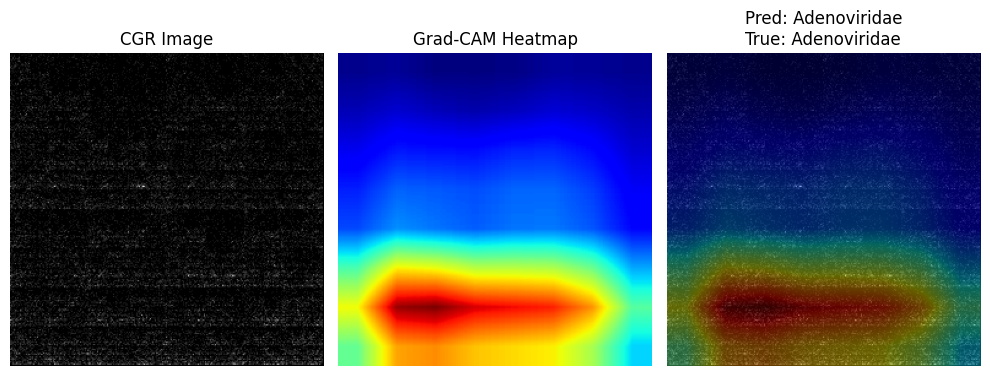

In [ ]:
# STEP 8B: Generate & SAVE one Grad-CAM figure

# pick a single random test image
idx = random.randrange(len(test_paths))
p = test_paths[idx]
y = test_labels[idx]
print("Image path:", p)
print("True family:", y)

img = Image.open(p).convert("L")
img_t = eval_transform(img)
img_t = img_t.repeat(3, 1, 1).unsqueeze(0).to(device)

# prediction
resnet.eval()
with torch.no_grad():
    outputs = resnet(img_t)
    pred_idx = outputs.argmax(dim=1).item()
pred_label = classes[pred_idx]
print("Predicted family:", pred_label)

# Grad-CAM heatmap
heatmap = gradcam(img_t, class_idx=pred_idx)
heatmap_resized = np.array(
    Image.fromarray((heatmap * 255).astype(np.uint8)).resize(img.size, resample=Image.BILINEAR)
)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(img, cmap="gray")
axes[0].set_title("CGR Image")
axes[0].axis("off")

axes[1].imshow(heatmap_resized, cmap="jet")
axes[1].set_title("Grad-CAM Heatmap")
axes[1].axis("off")

axes[2].imshow(img, cmap="gray")
axes[2].imshow(heatmap_resized, cmap="jet", alpha=0.4)
axes[2].set_title(f"Pred: {pred_label}\nTrue: {y}")
axes[2].axis("off")

plt.tight_layout()

gc_path = ROOT / "resnet18_gradcam_example.png"
plt.savefig(gc_path, dpi=300)
print("Saved Grad-CAM figure to:", gc_path)
plt.show()
